In [8]:
import sys
sys.path.append('../../code/')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_forward, hnn_rc_param_function, UniformPrior, linear_scale_array,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../../data/hnn_rc'

with open(f'{data_path}/posteriors/hnn_rc_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/hnn_rc_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples']

In [9]:
# Parameter bounds
for param_name, param_dict in prior_dict.items():
    print(f'{param_name}:{param_dict["bounds"]}', end=' ')

prox_weight:(-4, -3) dist_weight:(-4, -3) latency:(-75, 75) 

### Generate conditioning waveform

In [10]:
net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_rc_param_function,
                    network_model=net, tstop=tstop)

In [17]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.77, 0.9, 0.7]), np.array([0.77, 0.9, 0.3])]
psd_list = list()
x_cond_list = list()

for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float()).numpy()
    x_cond[:, :zero_samples] = np.repeat(x_cond[:, zero_samples], zero_samples).reshape(x_cond.shape[0], zero_samples)

    prior = UniformPrior(parameters=list(prior_dict.keys()))
    n_params = len(prior_dict)
    limits = list(prior_dict.values())

    x_cond_peak = get_dataset_peaks(x_cond.T)

    fs = posterior_metadata['fs'] # Frequency defined for PSD
    x_cond_psd, f = get_dataset_psd(x_cond, fs=fs)
    
    x_cond_list.append(x_cond)
    psd_list.append(x_cond_psd)

{'prox_weight': 0.0005888436294945623, 'dist_weight': 0.0007943281911173255, 'latency': 29.999998211860657}
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Sim

/home/ntolley/Jones_Lab/hnn_sbi_examples/notebooks/hnn_rc/../../code/utils.py:443: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32)


Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...
Simulation time: 250.0 ms...
Simulation time: 260.0 ms...
Simulation time: 270.0 ms...
Simulation time: 280.0 ms...
Simulation time: 290.0 ms...
Simulation time: 300.0 ms...
Simulation time: 310.0 ms...
Simulation time: 320.0 

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

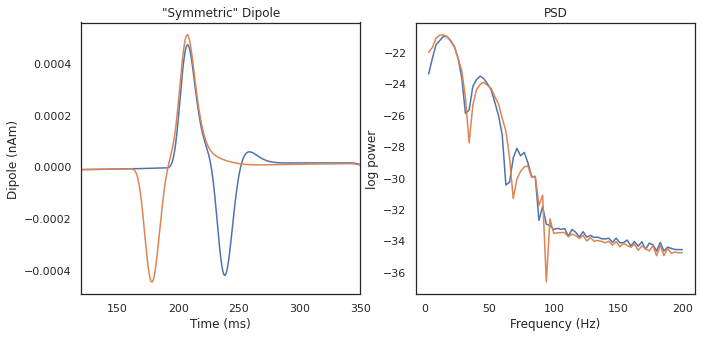

In [18]:
%matplotlib inline
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
t_vec = np.linspace(0, tstop, x_cond.shape[1])
plt.plot(t_vec, x_cond_list[0].squeeze())
plt.plot(t_vec, x_cond_list[1].squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Dipole (nAm)')
plt.xlim([120, 350])
#plt.ylim([-1.2,1.2])
plt.title('"Symmetric" Dipole')

plt.subplot(1,2,2)
plt.plot(f, psd_list[0].squeeze())
plt.plot(f, psd_list[1].squeeze())
plt.xlabel('Frequency (Hz)')
plt.ylabel('log power')
plt.title('PSD')

plt.tight_layout